In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, ResNet50, EfficientNetB0

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


# Verify Dataset Programmatically (Before Training)

In [2]:
import os

DATASET_DIR = r"C:\Users\LENOVO P14S\6th-Sem-Project\dataset"

classes = os.listdir(DATASET_DIR)
print("Classes:", classes)

for cls in classes:
    cls_path = os.path.join(DATASET_DIR, cls)
    print(f"{cls}: {len(os.listdir(cls_path))} images")


Classes: ['ripen', 'unripen']
ripen: 388 images
unripen: 629 images


# Load Images the RIGHT Way
#### This alone: Labels your data
#### Splits train/validation
#### Resizes images
#### Builds an efficient pipeline

In [3]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 16

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
print("Class names:", class_names)


Found 1017 files belonging to 2 classes.
Using 814 files for training.
Found 1017 files belonging to 2 classes.
Using 203 files for validation.
Class names: ['ripen', 'unripen']


# Normalize Images
### Neural networks do not like raw pixel values.

In [4]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


# Visual Sanity Check

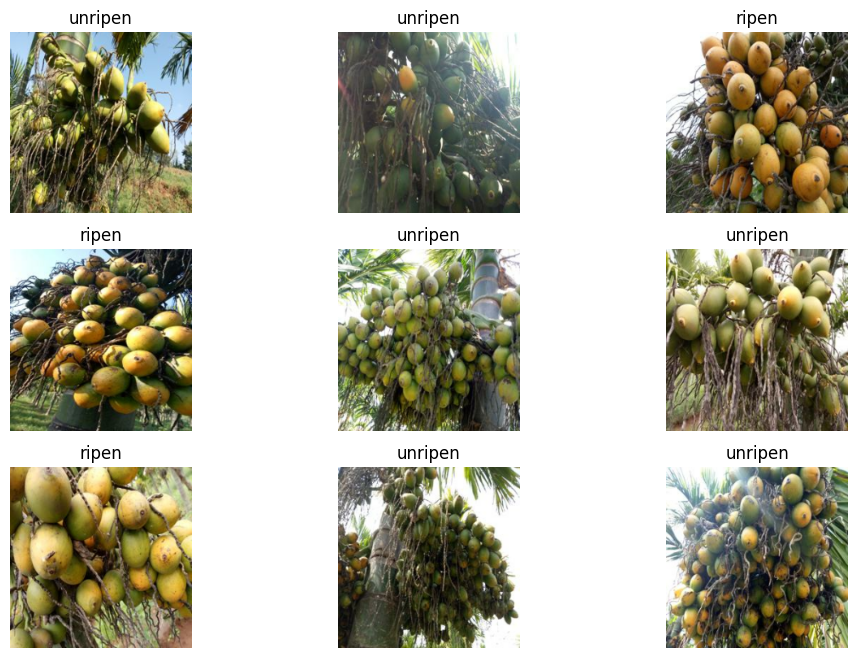

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i]])
        plt.axis("off")


# Class Imbalance

In [6]:
class_weight = {
    0: 629 / 388,   # ripen
    1: 1.0          # unripen
}


# Data Augmentation

In [7]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


# Build the Model
### Step 1: Load Base Model

In [8]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False


### Step 2: Custom Classification Head 
#### Binary problem → sigmoid

In [9]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)


### Step 3: Compile

In [10]:
model.compile(
    # optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    optimizer=keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=["accuracy","precision","Recall"]
)


# Train (Phase 1: Feature Extraction)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True
)


In [13]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=105,
    class_weight=class_weight
)

Epoch 1/105
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - Recall: 0.6407 - accuracy: 0.6413 - loss: 0.7991 - precision: 0.7413 - val_Recall: 0.3672 - val_accuracy: 0.4975 - val_loss: 0.6884 - val_precision: 0.6912
Epoch 2/105
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 205ms/step - Recall: 0.6208 - accuracy: 0.6339 - loss: 0.7915 - precision: 0.7422 - val_Recall: 0.4453 - val_accuracy: 0.5517 - val_loss: 0.6864 - val_precision: 0.7403
Epoch 3/105
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 223ms/step - Recall: 0.6527 - accuracy: 0.6536 - loss: 0.7565 - precision: 0.7517 - val_Recall: 0.5859 - val_accuracy: 0.5714 - val_loss: 0.6729 - val_precision: 0.6881
Epoch 4/105
51/51 ━━━━━━━━━━━━━━━━━━━━ 12s 224ms/step - Recall: 0.6567 - accuracy: 0.6695 - loss: 0.7450 - precision: 0.7723 - val_Recall: 0.8047 - val_accuracy: 0.6207 - val_loss: 0.6404 - val_precision: 0.6645
Epoch 5/105
51/51 ━━━━━━━━━━━━━━━━━━━━ 12s 238ms/step - Recall: 0.6707 - accuracy: 0.6806 - loss: 0.7320 - precision: 0.7796 - val_Recall: 0.7422 - val_

# CONFUSION MATRIX
### Step 1: Collect true labels and predictions

In [14]:
import numpy as np

y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    preds = (preds > 0.5).astype(int).flatten()

    y_true.extend(labels.numpy())
    y_pred.extend(preds)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


### Step 2: Generate confusion matrix

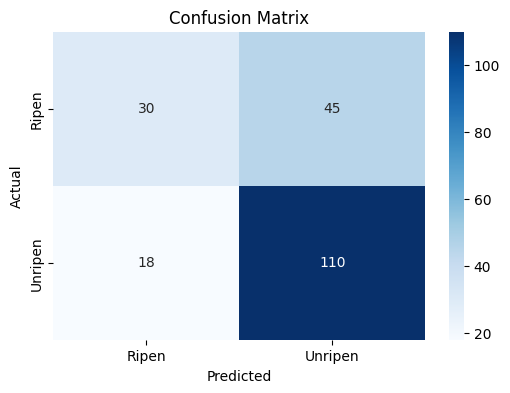

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["Ripen", "Unripen"],
            yticklabels=["Ripen", "Unripen"],
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# PRECISION, RECALL, F1

In [16]:
from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_pred,
    target_names=["Ripen", "Unripen"]
))


              precision    recall  f1-score   support

       Ripen       0.62      0.40      0.49        75
     Unripen       0.71      0.86      0.78       128

    accuracy                           0.69       203
   macro avg       0.67      0.63      0.63       203
weighted avg       0.68      0.69      0.67       203



# FINAL MODEL SAVING

In [ ]:
# model.save("arecanut_maturity.keras")


# TENSORFLOW LITE CONVERSION

In [ ]:
# import tensorflow as tf

# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

# tflite_model = converter.convert()

# with open("arecanut_maturity.tflite", "wb") as f:
#     f.write(tflite_model)
